# Preprocesamiento de Datos

En este cuaderno, vamos a realizar un preprocesamiento de datos utilizando `scikit-learn`. El preprocesamiento es una fase crítica en cualquier pipeline de machine learning, ya que asegura que los datos estén en un formato adecuado para entrenar modelos. Al final, también veremos cómo almacenar los objetos de preprocesamiento utilizando `joblib` y por qué es importante dentro de las prácticas de MLOps.

## Importación de Librerías
Primero, importamos todas las librerías necesarias. Estas incluyen herramientas de manipulación de datos (`pandas`, `numpy`), visualización (`seaborn`, `matplotlib`), y preprocesamiento (`scikit-learn`).

In [1]:
# Importamos librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import StandardScaler, MinMaxScaler,  OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from joblib import dump

## Carga de los Datos
Vamos a cargar un conjunto de datos que contiene información demográfica. Este dataset proviene de `data_adults.csv`, un conjunto de datos comúnmente utilizado para predecir el nivel de ingresos basado en características demográficas.

In [2]:
# Cargamos los datos
Data = pd.read_csv("../Datos/data_adults.csv")
Data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Exploración de Datos
Es importante conocer la estructura de los datos antes de preprocesarlos. Vamos a visualizar las primeras filas y también la estructura de tipos de datos en cada columna.

In [3]:
# Vista rápida de los datos
print(Data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB
None


## Eliminación de Columnas Irrelevantes
En muchos casos, algunos datos no aportan valor a nuestro modelo o pueden estar altamente correlacionados con otras variables. Aquí, eliminamos la columna `fnlwgt` (un peso final de la muestra) y `education-num` (número de años de educación, que ya está representado en la columna `education`).

In [4]:
# Eliminamos columnas irrelevantes
Data_cop = Data.drop("fnlwgt", axis=1).drop("education-num", axis=1)

## Separación de Variables y Objetivo
Dividimos los datos en dos partes: las características (`X`) y la variable objetivo (`y`), que en este caso es la columna `income`.

In [5]:
# Separación de Variables y Objetivo
X = Data_cop.drop("income", axis=1)
y = Data_cop['income'].isin(['>50K.','>50K'])

## Definición de Estrategia de Preprocesamiento
Aquí definimos diferentes estrategias de preprocesamiento para diferentes tipos de variables:

- Las variables categóricas necesitan ser codificadas utilizando técnicas como OneHotEncoder o OrdinalEncoder.
- Las variables numéricas pueden ser escaladas utilizando StandardScaler o MinMaxScaler.
- También es importante manejar los valores faltantes utilizando imputadores.

In [6]:
# Definimos las variables categóricas y numéricas
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Creamos pipelines de preprocesamiento
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Usamos ColumnTransformer para combinar ambas transformaciones
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## Random Forest

### Creación del Pipeline
Ahora combinamos el preprocesamiento en un pipeline. Esto nos permite encadenar las transformaciones de manera eficiente.

In [7]:
# Definimos el pipeline completo
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

### Entrenamiento de un Modelo con el Pipeline
Ahora que tenemos el pipeline de preprocesamiento configurado, vamos a entrenar un modelo. En este caso, usaremos un **RandomForestClassifier**, un algoritmo robusto y eficiente para tareas de clasificación.

In [8]:
# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creamos un nuevo pipeline que incluye el preprocesamiento y el modelo
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

# Entrenamos el pipeline completo en los datos de entrenamiento
model_pipeline.fit(X_train, y_train)

# Hacemos predicciones en el conjunto de prueba
y_pred = model_pipeline.predict(X_test)

# Evaluamos el rendimiento del modelo
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.88      0.92      0.90      7414
        True       0.71      0.61      0.66      2355

    accuracy                           0.85      9769
   macro avg       0.80      0.77      0.78      9769
weighted avg       0.84      0.85      0.84      9769



In [9]:
model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'capital-gain', 'capital-loss', 'hours-per-week'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [10]:
modelo_entrenado=model_pipeline['classifier']
preprocessor_entrenado=model_pipeline['preprocessor']

nombres=preprocessor_entrenado.get_feature_names_out()
importancia=modelo_entrenado.feature_importances_

df_features=pd.DataFrame()
df_features['nombres']=nombres
df_features['importancia']=importancia
df_features=df_features.sort_values('importancia',ascending=False)
df_features.head(20)

,nombres,importancia
0,num__age,0.230540
3,num__hours-per-week,0.115249
1,num__capital-gain,0.113666
31,cat__marital-status_Married-civ-spouse,0.068151
51,cat__relationship_Husband,0.048980
2,num__capital-loss,0.038220
33,cat__marital-status_Never-married,0.028357
22,cat__education_Bachelors,0.022635
40,cat__occupation_Exec-managerial,0.020666
46,cat__occupation_Prof-specialty,0.016576


<BarContainer object of 20 artists>

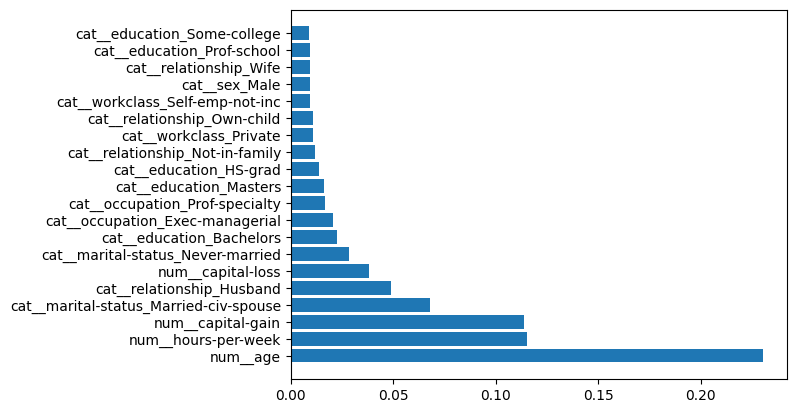

In [11]:
plt.barh(df_features.head(20)['nombres'],df_features.head(20)['importancia'])

### Guardar el Pipeline Completo (Preprocesador + Modelo)
Finalmente, guardamos el pipeline completo (incluyendo el modelo entrenado) en un archivo `joblib`.

In [12]:
# Guardamos el pipeline completo (preprocesamiento + modelo entrenado)
dump(model_pipeline, '../Modelos/model_pipeline_rf.joblib')

['../Modelos/model_pipeline_rf.joblib']

### ¿Por qué es esto importante en MLOps?

1. **Reproducibilidad**: Guardar el pipeline completo asegura que puedas reproducir exactamente las mismas transformaciones y predicciones en diferentes entornos.
2. **Automatización**: En un entorno MLOps, los pipelines automatizados son clave para la integración continua y el despliegue continuo (CI/CD). Guardar el modelo entrenado con `joblib` facilita esta automatización.
3. **Escalabilidad**: Al tener tanto el preprocesamiento como el modelo entrenado almacenados, puedes aplicarlos a nuevos datos sin necesidad de recalcular cada paso, lo que es esencial cuando se trabaja con grandes volúmenes de datos en producción.
4. **Consistencia**: Evitamos errores derivados de la aplicación inconsistente de transformaciones de datos, garantizando que los datos en producción se traten de la misma forma que en el entrenamiento.

### Optimización de hiperparámetros

Buscamos las mejores combinaciones de hiperparametros que mejoren el rendimiento del modelo.

In [13]:
X = Data_cop.drop("income", axis=1)
y = Data_cop['income'].isin(['>50K.','>50K'])

# Definimos las variables categóricas y numéricas
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Creamos pipelines de preprocesamiento
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Usamos ColumnTransformer para combinar ambas transformaciones
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ], sparse_threshold=0  # Esto asegura que la salida sea densa
)

### Búsqueda de hiperparametros

In [14]:
param_grid={
    'n_estimators':[50,100,150,200],
    'max_depth':[2,5,10],
    'min_samples_split':[2,5,10]
}
model_rf=RandomForestClassifier(random_state=2024)

#### Instanciamos la busqueda del mejor modelo

model_busqueda=GridSearchCV(estimator=model_rf,
                            param_grid=param_grid,
                            cv=3,
                            verbose=4,
                            scoring='f1',
                            n_jobs=-1)

model_pipeline_train_ranfo= Pipeline(steps=[('preprocessor', preprocessor),
                                 ('busqueda', model_busqueda)])

# Entrenamos el pipeline completo en los datos de entrenamiento
model_pipeline_train_ranfo.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


c:\Users\MSLV\.conda\envs\ml2024\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'capital-gain', 'capital-loss', 'hours-per-week'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_un...
                                                                                 sparse_output=False))]),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object'))])),
                ('busqueda',
                 GridSearchCV(cv=3,
                              estimator=RandomForestClassifier(random_state=2024),
                              n_jobs=-1,
                              param_grid={'max_depth': [2, 5, 10],
                                          'min_samples_split': [2, 5, 10],
                                          'n_estimators': [50, 100, 150, 200]},
                              scoring='f1', verbose=4))])

### Extraer el mejor modelo

In [15]:
busqueda_resultado_ranfo=model_pipeline_train_ranfo['busqueda']
busqueda_resultado_ranfo.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2024,
 'verbose': 0,
 'warm_start': False}

### Evalúar el rendimiento del modelo entrenado 

In [16]:
y_pred=model_pipeline_train_ranfo.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.86      0.96      0.91      7414
        True       0.82      0.52      0.63      2355

    accuracy                           0.86      9769
   macro avg       0.84      0.74      0.77      9769
weighted avg       0.85      0.86      0.84      9769



In [17]:
y_pred_train=model_pipeline_train_ranfo.predict(X_train)

print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

       False       0.87      0.97      0.92     29741
        True       0.83      0.54      0.65      9332

    accuracy                           0.86     39073
   macro avg       0.85      0.75      0.78     39073
weighted avg       0.86      0.86      0.85     39073



In [18]:
model_pipeline['classifier'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

# <span style="color:orange">Universidad EAN - Maestría en Ciencias de Datos</span>

## <span style="color:green">Clase - Machine Learning I</span>
## <span style="color:green">Presentado por Michel Stivens Larrota Villalba</span>

Se replica el mismo ejercicio pero aplicado a los cuatro (4) modelos objeto de la actividad, (Gradient Boosting, Naive Bayes, Máquinas de Vectores de Soporte y Regresión Logística)

## Gradient Boosting

### Creación del Pipeline y Entrenamiento de un Modelo con el Pipeline
Combinamos el preprocesamiento en un pipeline. Esto nos permite encadenar las transformaciones de manera eficiente, luego de tener el pipeline de preprocesamiento configurado, vamos a entrenar un modelo. En este caso, usaremos un **GradientBoostingClassifier**.

In [19]:
# Definimos el pipeline completo con Gradient Boosting
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', GradientBoostingClassifier(random_state=42))])

# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamos el pipeline completo en los datos de entrenamiento
model_pipeline.fit(X_train, y_train)

# Hacemos predicciones en el conjunto de prueba
y_pred = model_pipeline.predict(X_test)

# Evaluamos el rendimiento del modelo
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.88      0.96      0.91      7414
        True       0.80      0.57      0.67      2355

    accuracy                           0.86      9769
   macro avg       0.84      0.76      0.79      9769
weighted avg       0.86      0.86      0.85      9769



Visualización del modelo

In [20]:
model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'capital-gain', 'capital-loss', 'hours-per-week'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object'))])),
                ('classifier', GradientBoostingClassifier(random_state=42))])

Representatividad de las variables en el modelo

In [21]:
modelo_entrenado=model_pipeline['classifier']
preprocessor_entrenado=model_pipeline['preprocessor']

nombres=preprocessor_entrenado.get_feature_names_out()
importancia=modelo_entrenado.feature_importances_

df_features=pd.DataFrame()
df_features['nombres']=nombres
df_features['importancia']=importancia
df_features=df_features.sort_values('importancia',ascending=False)
df_features.head(20)

,nombres,importancia
31,cat__marital-status_Married-civ-spouse,0.414113
1,num__capital-gain,0.221639
2,num__capital-loss,0.069364
0,num__age,0.056305
3,num__hours-per-week,0.041829
22,cat__education_Bachelors,0.035746
40,cat__occupation_Exec-managerial,0.033620
25,cat__education_Masters,0.027437
46,cat__occupation_Prof-specialty,0.023822
27,cat__education_Prof-school,0.012713


Graficación de las variables en el modelo

<BarContainer object of 20 artists>

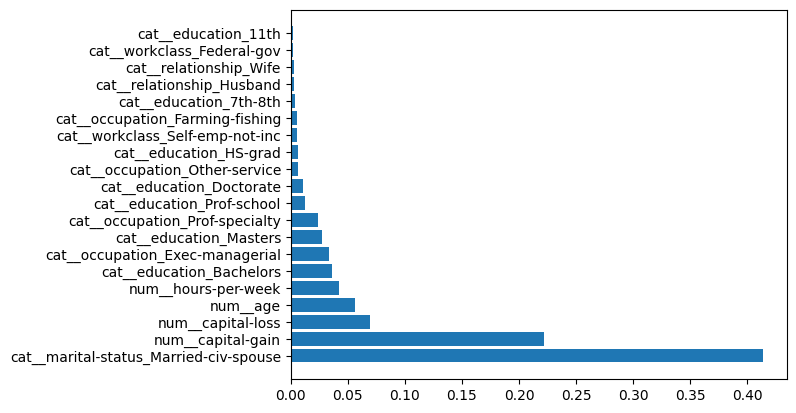

In [22]:
plt.barh(df_features.head(20)['nombres'],df_features.head(20)['importancia'])

### Guardar el Pipeline Completo (Preprocesador + Modelo)
Finalmente, guardamos el pipeline completo (incluyendo el modelo entrenado) en un archivo `joblib`.

In [23]:
# Guardamos el pipeline completo (preprocesamiento + modelo entrenado)
dump(model_pipeline, '../Modelos/model_pipeline_gb.joblib')

['../Modelos/model_pipeline_gb.joblib']

### Optimización, Entrenamiento y Evaluación del Modelo

Búsqueda de hiperparametros

In [24]:
# Parametros complementarios de entrenamiento, mejoran muy poco la precisión del modelo, pero tiene un alto costo de procesamiento Gradient Boosting
#param_grid = {
#    'classifier__n_estimators': [100, 200, 300, 500],        # Número de árboles en el ensamble
#    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],     # Tasa de aprendizaje
#    'classifier__max_depth': [3, 5, 7, 10],                  # Profundidad máxima de los árboles
#    'classifier__min_samples_split': [2, 5, 10, 20],         # Mínimo número de muestras para dividir un nodo
#    'classifier__min_samples_leaf': [1, 2, 5, 10]            # Establece el mínimo de muestras necesarias para ser una hoja en el árbol
#}

# Definimos la cuadrícula de hiperparámetros para Gradient Boosting
param_grid = {
    'classifier__n_estimators': [50, 100, 150, 200],   # Número de árboles en el ensamble
    'classifier__learning_rate': [0.01, 0.1, 0.2],     # Tasa de aprendizaje
    'classifier__max_depth': [2, 5, 10],               # Profundidad máxima de los árboles
    'classifier__min_samples_split': [2, 5, 10]        # Mínimo número de muestras para dividir un nodo
}

# Búsqueda de hiperparámetros
model_busqueda = GridSearchCV(estimator=model_pipeline,
                              param_grid=param_grid,
                              cv=3,                         # Validación cruzada de 3 folds
                              verbose=4,                    # Muestra información detallada del progreso
                              scoring='f1',                 # Optimiza según el F1-score
                              n_jobs=-1)                    # Usa todos los núcleos disponibles

# Entrenamos el pipeline con búsqueda de hiperparámetros
model_busqueda.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['age', 'capital-gain', 'capital-loss', 'hours-per-week'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('one...
                                                                         Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object'))])),
                                       ('classifier',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__max_depth': [2, 5, 10],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [50, 100, 150, 200]},
             scoring='f1', verbose=4)

Extracción del mejor modelo y sus parámetros

In [25]:
# Extraer el mejor modelo
mejor_modelo_gb = model_busqueda.best_estimator_

# Mostrar el mejor puntaje de la búsqueda
print("Mejor puntaje (f1):", model_busqueda.best_score_)

Mejor puntaje (f1): 0.7099521218607391


Generación de predicciones y evaluación del modelo

In [26]:
# Evaluar el rendimiento del modelo con los mejores hiperparámetros
y_pred = mejor_modelo_gb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.89      0.95      0.92      7414
        True       0.79      0.64      0.71      2355

    accuracy                           0.87      9769
   macro avg       0.84      0.79      0.81      9769
weighted avg       0.87      0.87      0.87      9769



## Naive Bayes

### Creación del Pipeline y Entrenamiento de un Modelo con el Pipeline
Definimos el modelo, cargamos los parametros y buscamos los hiperparametrosCombinamos el preprocesamiento en un pipeline. Esto nos permite encadenar las transformaciones de manera eficiente, luego de tener el pipeline de preprocesamiento configurado, vamos a entrenar un modelo. 

In [27]:
# Definimos el modelo de Naive Bayes
model_nb = GaussianNB()

# Creamos el pipeline que incluye el preprocesamiento y el modelo
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', model_nb)])

# Definimos la grilla de hiperparámetros para Naive Bayes
param_grid = {
    'classifier__var_smoothing': np.logspace(-9, 0, 10)
}

# Realizamos la búsqueda de hiperparámetros con GridSearchCV
grid_search = GridSearchCV(
    model_pipeline,
    param_grid=param_grid,
    cv=3,
    verbose=4,
    scoring='f1',
    n_jobs=-1
)

# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamos el pipeline completo en los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Hacemos predicciones en el conjunto de prueba
y_pred = grid_search.predict(X_test)

# Evaluamos el rendimiento del modelo
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
              precision    recall  f1-score   support

       False       0.94      0.76      0.84      7414
        True       0.53      0.86      0.66      2355

    accuracy                           0.78      9769
   macro avg       0.74      0.81      0.75      9769
weighted avg       0.84      0.78      0.80      9769



Visualización del modelo

In [28]:
grid_search

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['age', 'capital-gain', 'capital-loss', 'hours-per-week'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('one...
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object'))])),
                                       ('classifier', GaussianNB())]),
             n_jobs=-1,
             param_grid={'classifier__var_smoothing': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00])},
             scoring='f1', verbose=4)

### Guardar el Pipeline Completo (Preprocesador + Modelo)
Extracción del mejor modelo y sus parámetros

In [29]:
# Mostramos los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

Mejores hiperparámetros: {'classifier__var_smoothing': np.float64(0.01)}


Finalmente, guardamos el pipeline completo (incluyendo el modelo entrenado) en un archivo `joblib`.

In [30]:
# Guardamos el pipeline completo (preprocesamiento + mejor modelo entrenado)
dump(grid_search, '../Modelos/model_pipeline_nb_best.joblib')

['../Modelos/model_pipeline_nb_best.joblib']

## Máquinas de Vectores de Soporte

### Creación del Pipeline y Entrenamiento de un Modelo con el Pipeline
Definimos el modelo, cargamos los parametros y buscamos los hiperparametrosCombinamos el preprocesamiento en un pipeline. Esto nos permite encadenar las transformaciones de manera eficiente, luego de tener el pipeline de preprocesamiento configurado, vamos a entrenar un modelo. 

In [31]:
# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creamos el modelo y la grilla de hiperparámetros para SVM
model_svm = SVC(random_state=42)
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto']
}

# Configuramos el pipeline y la búsqueda de hiperparámetros con GridSearchCV
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', model_svm)])

grid_search = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    verbose=4,
    n_jobs=-1
)

# Entrenamos el pipeline con GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['age', 'capital-gain', 'capital-loss', 'hours-per-week'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('one...
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object'))])),
                                       ('classifier', SVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1, 10, 100],
                         'classifier__gamma': ['scale', 'auto'],
                         'classifier__kernel': ['linear', 'rbf']},
             scoring='f1', verbose=4)

Extracción del mejor modelo y sus parámetros

In [32]:
# Extraemos el mejor modelo encontrado
best_model = grid_search.best_estimator_
print("Mejores hiperparámetros:", grid_search.best_params_)

Mejores hiperparámetros: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}


### Guardar el Pipeline Completo (Preprocesador + Modelo)
Se evalua el modelo y sus parámetros

In [33]:
# Evaluamos el rendimiento del modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.88      0.94      0.91      7414
        True       0.76      0.60      0.67      2355

    accuracy                           0.86      9769
   macro avg       0.82      0.77      0.79      9769
weighted avg       0.85      0.86      0.85      9769



Finalmente, guardamos el pipeline completo (incluyendo el modelo entrenado) en un archivo `joblib`.

In [34]:
# Guardamos el pipeline completo (preprocesamiento + modelo entrenado)
dump(best_model, '../Modelos/model_pipeline_svm.joblib')

['../Modelos/model_pipeline_svm.joblib']

## Regresión Logística

### Creación del Pipeline y Entrenamiento de un Modelo con el Pipeline
Definimos el modelo, cargamos los parametros y buscamos los hiperparametrosCombinamos el preprocesamiento en un pipeline. Esto nos permite encadenar las transformaciones de manera eficiente, luego de tener el pipeline de preprocesamiento configurado, vamos a entrenar un modelo. 

In [35]:
# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creamos el modelo de Regresión Logística y definimos el espacio de hiperparámetros
model_logreg = LogisticRegression(random_state=42, max_iter=1000)
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['lbfgs', 'liblinear'],
}

# Configuramos el pipeline y la búsqueda de hiperparámetros con GridSearchCV
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', model_logreg)])

grid_search = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    verbose=4,
    n_jobs=-1
)

# Entrenamos el pipeline con GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['age', 'capital-gain', 'capital-loss', 'hours-per-week'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('one...
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object'))])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.01, 0.1, 1, 10, 100],
                         'classifier__solver': ['lbfgs', 'liblinear']},
             scoring='f1', verbose=4)

Extracción del mejor modelo y sus parámetros

In [36]:
# Extraemos el mejor modelo encontrado
best_model = grid_search.best_estimator_
print("Mejores hiperparámetros:", grid_search.best_params_)

Mejores hiperparámetros: {'classifier__C': 1, 'classifier__solver': 'lbfgs'}


### Guardar el Pipeline Completo (Preprocesador + Modelo)
Se evalua el modelo y sus parámetros

In [37]:
# Evaluamos el rendimiento del modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.87      0.93      0.90      7414
        True       0.74      0.58      0.65      2355

    accuracy                           0.85      9769
   macro avg       0.81      0.76      0.78      9769
weighted avg       0.84      0.85      0.84      9769



Finalmente, guardamos el pipeline completo (incluyendo el modelo entrenado) en un archivo `joblib`.

In [38]:
# Guardamos el pipeline completo (preprocesamiento + modelo entrenado)
dump(best_model, '../Modelos/model_pipeline_logreg.joblib')

['../Modelos/model_pipeline_logreg.joblib']

### <span style="color:orange">Conclusión y Recomendación</span>

Se realiza el respectivo análisis de cada modelo, tomando como referente Random Forest, siendo este el realizado en clase y que cuenta con un volumen mayor de datos de entrenamiento y prueba. 

**1. Random Forest**

Exactitud (accuracy): 86%
F1-score para la clase True: 0.65

Análisis: El modelo presenta una exactitud alta y un buen rendimiento para la clase False (F1-score de 0.92), los resultados generados para la clase True (F1-score de 0.65) son más bajos. Esto permite inferir que el modelo podría estar desequilibrado en su predicción, especialmente frente al componente de valores True que tiene la muestra de datos.

**2. Gradient Boosting**

Exactitud (accuracy): 87%
F1-score para la clase True: 0.71

Análisis: Gradient Boosting presenta una exactitud alta (87%) y el mejor F1-score en la clase True (0.71), lo que permite es favorable teniendo en cuenta escenarios donde las dos clases son importantes. El modelo tiene un mejor rendimiento general, siendo el más balanceado de todos.

**3. Naive Bayes**

Exactitud (accuracy): 78%
F1-score para la clase True: 0.66

Análisis: Aunque Naive Bayes obtiene una precisión más alta para la clase False (0.94), su rendimiento general es más bajo (exactitud de 78%), y tiene problemas para predecir correctamente la clase True, con una exhaustividad notablemente alta (0.86) pero una precisión baja (0.53), se debe tener en cuenta para estos valores el bajo número de elementos True dentro de la muestra de datos.

**4. Máquinas de Vectores de Soporte (SVM)**

Exactitud (accuracy): 86%
F1-score para la clase True: 0.67

Análisis: El modelo SVM muestra un rendimiento equilibrado y obtiene una buena precisión en ambas clases, aunque no alcanza el rendimiento de Gradient Boosting en términos de f1-score para la clase True.

**5. Regresión Logística**

Exactitud (accuracy): 85%
F1-score para la clase True: 0.65

Análisis: La Regresión Logística tiene un rendimiento similar al de Random Forest, con un buen balance, aunque su exactitud es ligeramente menor. El rendimiento para la clase True también es menor en comparación con Gradient Boosting.

**Conclusión y Mejor Modelo**

Mejor modelo: Gradient Boosting

El modelo se destaca por tener la mayor exactitud (87%) y el F1-score para la clase True de 0.71 más alto de todos, siendo el mejor entre los modelos probados para capturar tanto la precisión como la exhaustividad de ambas clases de manera equilibrada.

Análisis: Aunque Random Forest y Regresión Logística tienen una exactitud similar, el modelo de Gradient Boosting logra un mejor balance en las métricas clave (especialmente en el F1-score de la clase True), siendo la mejor elección en términos generales.